# Age discrepancy

Now we will try to correlate age discrepancy with some scores of the behavioral dataset. Our model to predict age uses only the structural MRI features.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import create_dataset_mri, cv_for_cde, create_dataset_eeg
from cde.density_estimator import MixtureDensityNetwork
import numpy as np
import tensorflow as tf
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.python.keras.activations import tanh
from sklearn.impute import SimpleImputer
import pandas as pd
import tensorflow as tf

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Behavioral data
behavioral = pd.read_csv('data/Behavioral/cleaned/HBNFinalSummaries.csv')
# Create dataset MRI
target = 'Age'
data = create_dataset_mri(SCORE = target)
data.drop(columns=['DX_01_Cat', 'DX_01_Sub', 'DX_01'], inplace=True)

In [3]:
# labels and features
y = data[target]
X = data.drop([target], axis=1)
X = np.array(X)
y = np.array(y)

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=8)   #rs=2
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
ID_train = X_train[:,0]
X_train = X_train[:,1:]
ID_test = X_test[:,0]
X_test = X_test[:,1:]
y_train = np.array(y_train, dtype=np.float64)
X_train = np.array(X_train, dtype=np.float64)
y_test = np.array(y_test, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
print(X_train.shape)

(573, 369)


In [4]:
# Set model parameters
ndim_x=X_train.shape[1]
ndim_y=y_train.shape[1]
# We try the "faster decay rate for non-gaussian data" proposed in the paper: h = n^(-1/(d+1))
n = X_train.shape[0]
d = X_train.shape[1]+y_train.shape[1]
h = n**(-1/(d+1))
# Define the model
model = MixtureDensityNetwork('MDN', ndim_x, ndim_y, n_centers=10, hidden_sizes=(16, 16), hidden_nonlinearity=tf.nn.tanh,
               n_training_epochs=1000, x_noise_std=h, y_noise_std=h, adaptive_noise_fn=None, entropy_reg_coef=0.0,
               weight_decay=0.0, weight_normalization=True, data_normalization=True, dropout=0.0, l2_reg=0.0, l1_reg=0.0,
               random_seed=42)
# Fit
model.fit(X_train, y_train)
# Predict
y_pred = model.mean_(X_test)
y_pred = y_pred.reshape((-1,1))
y_pred.shape
print('Test MSE: {}'.format(mean_squared_error(y_pred, y_test)))

1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | loss: 843.535
mean log-loss train: 1.4721
Test MSE: 6.151568493625076


In [5]:
# Define discrepancy
std = model.std_(X_test)
discrepancy = np.divide((y_test-y_pred), std)
#discrepancy = y_test-y_pred

In [6]:
# Get dataframe for test observations with behavioral data + discrepancy
data = {'discrepancy':discrepancy[:,0]}
discrepancy_df = pd.DataFrame(data)
ID_df = pd.DataFrame({'EID':ID_test})
discrepancy_merged = pd.concat([ID_df, discrepancy_df], axis=1)
dataframe = pd.merge(discrepancy_merged, behavioral, how='inner', on='EID')
dataframe = dataframe.drop(['Anonymized.ID', 'Study.Site'], axis = 1)

In [7]:
# Get the correlations
correlations = dataframe[dataframe.columns[1:]].corr()['discrepancy'][:]
# Inspect correlations
correlations[correlations > 0.3]  

discrepancy                      1.000000
Age                              0.330567
DX_04_New                        0.371284
DX_05_RC                         0.321887
DX_06_New                        0.848740
DX_07_RC                         1.000000
DX_07_New                        1.000000
CELF_WS_R                        0.300385
CELF_FS_R                        0.439604
CELF_SA_R                        0.340363
CLEF5M_MM_Raw                    0.335413
sib3dxse                         0.388871
TRF_Pre_Attention_Raw            0.365677
TRF_Pre_Anxious.Depressed_Raw    0.310884
VL_Comm1_Raw                     0.471603
VL_Comm_Stnd                     0.973257
VL_DLS_Scale                     0.577572
VL_Social_Scale                  0.657486
WASI_BD_Raw                      0.311581
Name: discrepancy, dtype: float64

In [8]:
# Frequencies of major disturb in behavioral dataset
dataframe['DX_01'].value_counts()

ADHD-Combined Type                                                  117
ADHD-Inattentive Type                                                97
No Diagnosis Given                                                   79
No Diagnosis Given: Incomplete Eval                                  50
Specific Learning Disorder with Impairment in Reading                33
Autism Spectrum Disorder                                             28
Generalized Anxiety Disorder                                         21
Social Anxiety (Social Phobia)                                       13
Major Depressive Disorder                                            13
Other Specified Attention-Deficit/Hyperactivity Disorder             12
ADHD-Hyperactive/Impulsive Type                                      12
Language Disorder                                                    10
Other Specified Anxiety Disorder                                      8
Intellectual Disability-Mild                                    

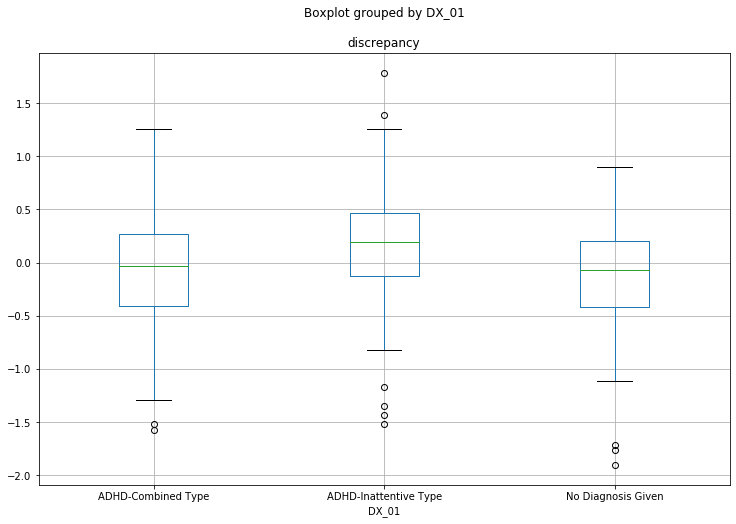

In [9]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Inattentive Type', 'ADHD-Combined Type', 'No Diagnosis Given'])]
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

## ANOVA

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

             sum_sq     df         F    PR(>F)
DX_01      4.071815    2.0  6.510555  0.001715
Residual  90.685551  290.0       NaN       NaN


In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.511
Date:                Wed, 13 Nov 2019   Prob (F-statistic):            0.00171
Time:                        10:42:57   Log-Likelihood:                -243.94
No. Observations:                 293   AIC:                             493.9
Df Residuals:                     290   BIC:                             504.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0435      0.052     -0.842      0.400      -0.145       0.058
DX_01[T.ADHD-Inattentive Type]     0.1963      0.077      2.557      0.011       0.045       0.347
DX_01[T.No Diagnosis Given]       -0.0985      0.081     -1.209      0.227      -0.259       0.062
==============================================================================
Omnibus:                       12.781   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.127
Skew:                          -0.368   Prob(JB):                     0.000315
Kurtosis:                       3.883   Cond. No.                         3.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

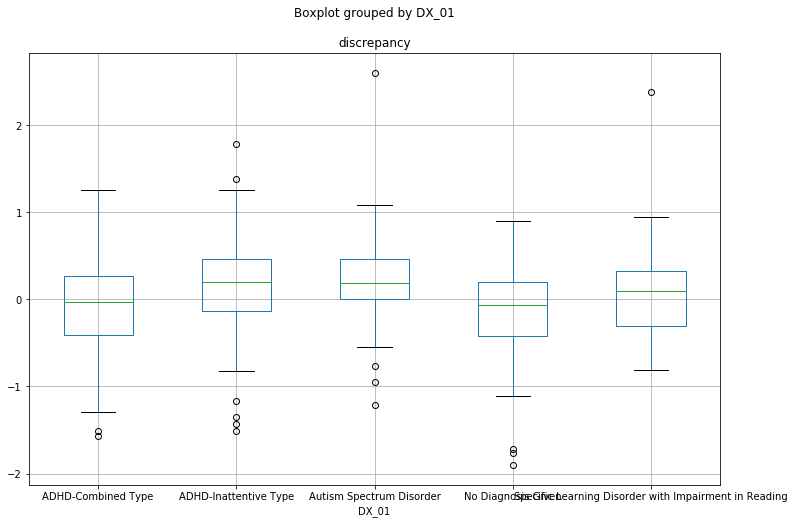

In [12]:
df = dataframe.loc[dataframe['DX_01'].isin(['ADHD-Combined Type', 'ADHD-Inattentive Type','No Diagnosis Given', 'Autism Spectrum Disorder', 'Specific Learning Disorder with Impairment in Reading'])]
#Create a boxplot
df.boxplot('discrepancy', by='DX_01', figsize=(12, 8))

In [13]:
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

              sum_sq     df         F    PR(>F)
DX_01       5.751756    4.0  4.348008  0.001915
Residual  115.418554  349.0       NaN       NaN


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            discrepancy   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.348
Date:                Wed, 13 Nov 2019   Prob (F-statistic):            0.00191
Time:                        10:42:58   Log-Likelihood:                -303.93
No. Observations:                 354   AIC:                             617.9
Df Residuals:                     349   BIC:                             637.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         -0.0435      0.053     -0.819      0.413      -0.148       0.061
DX_01[T.ADHD-Inattentive Type]                                     0.1963      0.079      2.486      0.013       0.041       0.352
DX_01[T.Autism Spectrum Disorder]                                  0.2679      0.121      2.214      0.027       0.030       0.506
DX_01[T.No Diagnosis Given]                                       -0.0985      0.084     -1.176      0.240      -0.263       0.066
DX_01[T.Specific Learning Disorder with Impairment in Reading]     0.1641      0.113      1.448      0.148      -0.059       0.387
==============================================================================
Omnibus:                       17.218   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.708
Skew:                           0.007   Prob(JB):                     1.19e-10
Kurtosis:                       4.760   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Consider all the diseases, F-test still significant.
model = ols('discrepancy ~ DX_01',                 # Model formula
            data = dataframe).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print (anova_result)

              sum_sq     df         F    PR(>F)
DX_01      27.143087   39.0  1.967207  0.000593
Residual  184.677945  522.0       NaN       NaN
